This lab on PCS and PLS is a python adaptation of p. 256-259 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. 
This notebook is based on the original adaptation by J. Warmenhoven and updated by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).


Before you start upgrade your scikit-learn library to version 1.0. 

In [26]:
def check_sklearn():
    from importlib_metadata import metadata
    version = metadata('scikit-learn').get('Version')
    # print(version)
    major, minor = list(map(int, version.split('.')[:2]))
    if major==0:
        print(f"sklearn version is {version}, please upgrade by uncommenting and running the next cell!")
    else:
        print(f"Your sklearn version=`{version}` seems to be up to date") 
check_sklearn()

'1.0'

In [ ]:
#! pip install -U scikit-learn



### 6.5.3 Principal Components Regression

Principal components regression (PCR) can be performed using the `PCA()`
function, which is part of the `sklearn` library. In this lab, we'll apply PCR to the `Hitters`
data, in order to predict `Salary`. As in previous labs, we'll start by ensuring that the missing values have
been removed from the data:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import statsmodels.datasets as smd

Let's set up our data:

In [2]:
df = smd.get_rdataset('Hitters', 'ISLR')
df.data.__doc__ = df.__doc__
df = df.data.dropna()

dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
print(dummies.head())
df = df.drop(columns=['League', 'Division', 'NewLeague']).astype('float64')
df = pd.concat([df, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

df.info()
df.head()

                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
-Alan Ashby                  1  
-Alvin Davis                 0  
-Andre Dawson                1  
-Andres Galarraga            1  
-Alfredo Griffin             0  
<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.5,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,750.0,0,1,0


A helper function to get `X` and `y`

In [4]:
def extract(df, response='Salary', return_dict=True):
    X, y = df.drop(columns=[response]), df[response]
    if return_dict:
        return dict(X=X, y=y)
    else:
        return X, y

Unfortunately `sklearn` does not have an implementation of PCA and regression combined like the `pls`, package in R: https://cran.r-project.org/web/packages/pls/vignettes/pls-manual.pdf so we'll have to do it ourselves.

We'll start by performing Principal Components Analysis (PCA), remembering to scale the data.

First how to scale the data:

train
             AtBat          Hits         HmRun          Runs           RBI  \
mean  7.664484e-17  1.149673e-16  7.664484e-17 -6.086502e-17 -7.213632e-17   
std   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             Walks         Years        CAtBat         CHits        CHmRun  \
mean  8.115336e-17 -8.791614e-17 -1.217300e-16 -6.311928e-17 -5.410224e-17   
std   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             CRuns          CRBI        CWalks       PutOuts       Assists  \
mean -7.664484e-17  8.340762e-17  4.959372e-17 -7.636306e-17  1.803408e-17   
std   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

            Errors      League_N    Division_W   NewLeague_N  
mean -1.803408e-17  5.861076e-17  5.579293e-17 -1.127130e-17  
std   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
test
         AtBat      Hits     HmRun      Runs       RBI     Walks     Years  \
mean  0.232013  0

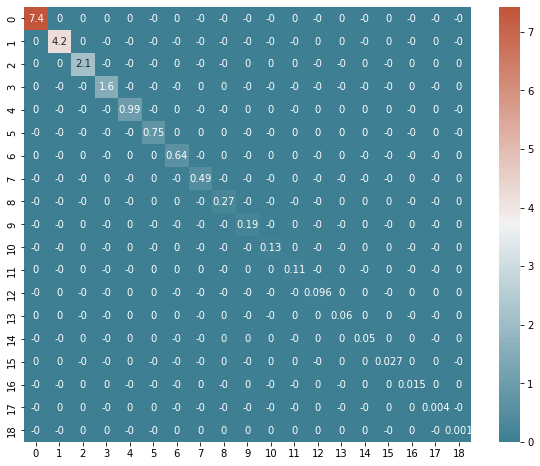

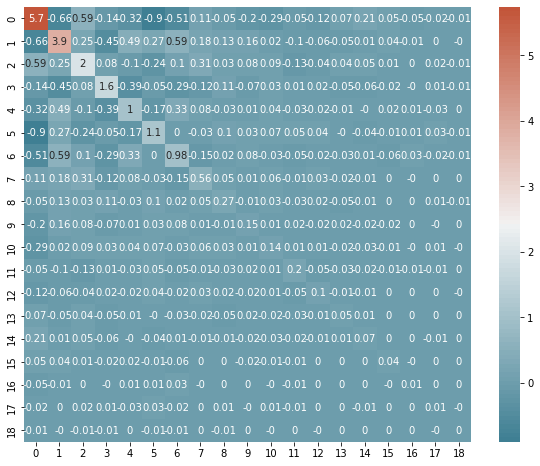

In [6]:
np.random.seed(1)
df_train,df_test = train_test_split(df)

scaler = StandardScaler().fit(**extract(df_train))

scaled_test_X = pd.DataFrame(scaler.transform(extract(df_test)['X']), columns=scaler.feature_names_in_)
scaled_train_X = pd.DataFrame(scaler.transform(extract(df_train)['X']), columns=scaler.feature_names_in_)


def std(x):
    return x.std(ddof=0)

print('='*50)
print('train')
print(scaled_train_X.aggregate(['mean', std], axis=0))
print('='*50)
print('test')
print(scaled_test_X.aggregate(['mean', std], axis=0)) 
                            

pca = make_pipeline(StandardScaler(), PCA())

pca_train_X = pca.fit_transform(**extract(df_train))
pca_test_X = pca.transform(extract(df_test)['X'])

plt.figure(figsize=(10,8))
sns.heatmap(np.cov(pca_train_X, rowvar=False).round(3), #vmin=-1, vmax=1, 
            annot=True, cmap=sns.diverging_palette(220, 20, n=100))
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(np.cov(pca_test_X, rowvar=False).round(2), #vmin=-1, vmax=1, 
            annot=True, cmap=sns.diverging_palette(220, 20, n=100))
plt.show()

Let's print out the first few variables of the first few principal components:

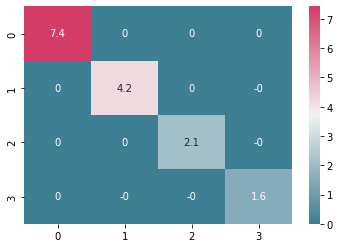

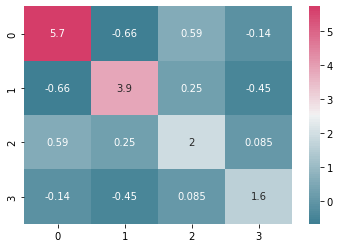

,0,1,2,3
0,-0.457094,0.285956,0.671906,-1.126024
1,0.485816,2.446991,0.998471,-0.761955
2,-0.934629,-2.053285,0.064515,2.105411
3,-1.054972,-0.752726,-1.012745,1.123829
4,-2.505855,1.563399,-1.551197,0.424566


In [7]:
class FirstK:
    def __init__(self, k):
        self.k = k
    
    def transform(self, X, **kwargs):
        if self.k>0:
            return X[:,:self.k]
        else:
            # return only the constant term for k=0
            # by default it is included in LinearRegression, 
            # but it causes no harm
            # and X[:,:0] would make LinearRegression to raise an error 
            return np.ones((X.shape[0],1))
    
    def fit(self, X, y=None, **kwargs):
        return self

pca = make_pipeline(StandardScaler(), PCA(), FirstK(4))

pca_train_X = pd.DataFrame(pca.fit_transform(**extract(df_train)))
pca_test_X = pd.DataFrame(pca.transform(extract(df_test)['X']))


sns.heatmap(pca_train_X.cov().round(5), #vmin=-1, vmax=1, 
            annot=True, cmap=sns.diverging_palette(220, 0, n=100))
plt.show()

sns.heatmap(pca_test_X.cov().round(5), #vmin=-1, vmax=1, 
            annot=True, cmap=sns.diverging_palette(220, 0, n=100))
plt.show()

pca_train_X.head()

Now we'll perform 10-fold cross-validation to see how it influences the MSE. We use the `cross_val_score` function of `sklearn.model_selection` imported as `cv_score`. The default `score` for  `LinearRegression` is the $R^2$ statistic.

In [12]:
def mk_model(k):
     return make_pipeline(StandardScaler(),
                          PCA(),
                          FirstK(k),
                          LinearRegression())

np.random.seed(1)

R2 = {k: cv_score(mk_model(k), 
                **extract(df), # X, y
                cv=10, # number of folds
                # scoring='neg_mean_squared_error'
                ) for k in range(0,20)}

print('done')

done


In [13]:
pd.DataFrame(R2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.059914,0.447492,0.376289,0.332859,0.266896,0.255129,0.249211,0.258564,0.242029,0.237987,0.234108,0.238308,0.238294,0.167500,-0.318611,-0.415800,-0.340157,-0.274169,-0.201371,-0.225765
1,-0.070755,0.608944,0.666914,0.651386,0.640013,0.598851,0.579681,0.593166,0.593633,0.602247,0.621409,0.622548,0.622806,0.610404,0.631287,0.625485,0.621114,0.675223,0.717758,0.708597
2,-0.123453,0.380352,0.413548,0.410492,0.440369,0.444904,0.475462,0.459658,0.456303,0.462562,0.480984,0.468892,0.468456,0.474168,0.517423,0.522684,0.581347,0.595525,0.615082,0.612754
3,-0.016987,0.416917,0.458487,0.433236,0.455416,0.493892,0.480703,0.479335,0.481679,0.484806,0.456780,0.456010,0.452620,0.465871,0.545804,0.566140,0.584792,0.576606,0.562856,0.558983
4,-0.009880,0.526150,0.495875,0.505882,0.502359,0.544761,0.590768,0.598623,0.598373,0.602263,0.634280,0.634893,0.630428,0.604980,0.674999,0.662067,0.711857,0.691010,0.678464,0.675773
5,-0.036980,0.536169,0.542691,0.562876,0.609345,0.590898,0.662836,0.666207,0.653863,0.654735,0.644934,0.637245,0.639111,0.639786,0.628329,0.629915,0.632006,0.611042,0.649894,0.650140
6,-0.002354,-0.036223,-0.110714,-0.089286,-0.085446,-0.040815,-0.029468,-0.028342,-0.044708,-0.047608,-0.065126,-0.064613,-0.069761,-0.059600,-0.000420,0.002964,0.032623,0.041579,0.006275,-0.013480
7,-0.011350,0.118277,0.196314,0.218054,0.217089,0.255424,0.225922,0.193635,0.208577,0.201890,0.095258,0.095298,0.040210,0.015993,0.109036,0.102359,-0.016507,-0.024924,0.025760,0.002920
8,-0.215957,0.574604,0.420518,0.292068,0.377908,0.345374,0.210567,0.208976,0.211393,0.157968,0.115003,0.110256,0.106648,0.131051,0.203445,0.205197,0.043227,-0.104846,-0.135767,-0.140358
9,-0.037440,0.178507,0.184643,0.206094,0.214722,0.242631,0.262565,0.283274,0.276967,0.270357,0.232503,0.226724,0.226291,0.244578,0.296751,0.264435,0.371807,0.437389,0.421593,0.416149


In [14]:
# LinearRegression.score?

In [15]:
R2_df = pd.DataFrame(R2).T 
R2_df

,0,1,2,3,4,5,6,7,8,9
0,-0.059914,-0.070755,-0.123453,-0.016987,-0.009880,-0.036980,-0.002354,-0.011350,-0.215957,-0.037440
1,0.447492,0.608944,0.380352,0.416917,0.526150,0.536169,-0.036223,0.118277,0.574604,0.178507
2,0.376289,0.666914,0.413548,0.458487,0.495875,0.542691,-0.110714,0.196314,0.420518,0.184643
3,0.332859,0.651386,0.410492,0.433236,0.505882,0.562876,-0.089286,0.218054,0.292068,0.206094
4,0.266896,0.640013,0.440369,0.455416,0.502359,0.609345,-0.085446,0.217089,0.377908,0.214722
5,0.255129,0.598851,0.444904,0.493892,0.544761,0.590898,-0.040815,0.255424,0.345374,0.242631
6,0.249211,0.579681,0.475462,0.480703,0.590768,0.662836,-0.029468,0.225922,0.210567,0.262565
7,0.258564,0.593166,0.459658,0.479335,0.598623,0.666207,-0.028342,0.193635,0.208976,0.283274
8,0.242029,0.593633,0.456303,0.481679,0.598373,0.653863,-0.044708,0.208577,0.211393,0.276967
9,0.237987,0.602247,0.462562,0.484806,0.602263,0.654735,-0.047608,0.201890,0.157968,0.270357


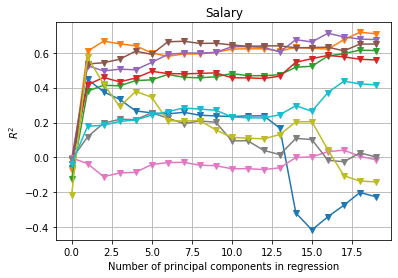

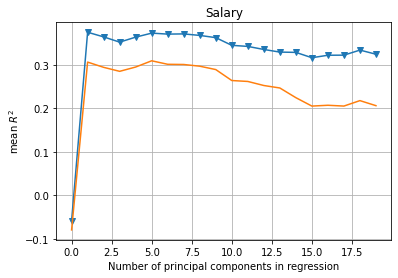

In [16]:

# Plot results    
plt.plot(R2_df, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('$R^2$')
plt.title('Salary')
#plt.xlim(xmin=-1)
#plt.xlim(xmax=20)
plt.grid()
plt.show()


# Plot results    
plt.plot(R2_df.mean(axis=1), '-v')
plt.plot(R2_df.mean(axis=1)-R2_df.std(axis=1)/(R2_df.shape[1]**0.5))
plt.xlabel('Number of principal components in regression')
plt.ylabel('mean $R^2$')
plt.title('Salary')
#plt.xlim(xmin=-1)
#plt.xlim(xmax=20)
plt.grid()
plt.show()


We see that the smallest cross-validation error occurs when $M = 1$ components
are used.
<!--This is barely fewer than $M = 19$, which amounts to
simply performing least squares, because when all of the components are
used in PCR no dimension reduction occurs. However, from the plot we
also see that the cross-validation error is roughly the same when only one
component is included in the model.-->
This suggests that a model that uses
just a small number of components might suffice.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component:

In [17]:
np.round(np.cumsum(pca['pca'].explained_variance_ratio_)*100, decimals=2)

array([ 38.89,  60.77,  71.88,  80.02,  85.19,  89.12,  92.45,  95.04,
        96.43,  97.42,  98.09,  98.67,  99.18,  99.49,  99.76,  99.9 ,
        99.97,  99.99, 100.  ])

We'll dig deeper into this concept in Chapter 10, but for now we can think of this as the amount of information about the predictors or the response that is captured using $M$ principal components. For example,
setting $M = 1$ only captures 38.31% of all the variance, or information, in
the predictors. In contrast, using $M = 6$ increases the value to 88.63%. If
we were to use all $M = p = 19$ components, this would increase to 100%.

Now let's perform PCA on the training data and evaluate its test set
performance:

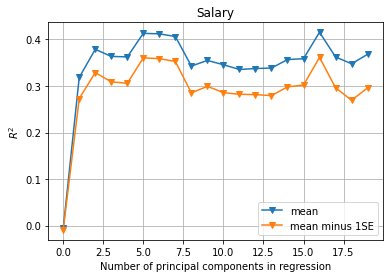

In [18]:
# set the random seed!
np.random.seed(9)
# Split into training and test sets
df_train, df_test = train_test_split(df, test_size=0.5)

def mean_std(x):
    return {'mean': x.mean(), 'mean_std': x.std()/(len(x)**0.5)}

scores = pd.DataFrame([mean_std(cv_score(mk_model(i), 
                                         **extract(df_train), 
                                         cv=4)
                               )
                       for i in np.arange(0, 20)])

#plt.plot(scores, '-v')
scores['mean minus 1SE'] = scores['mean']-scores.mean_std 
scores[['mean', 'mean minus 1SE']].plot(marker='v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('$R^2$')
plt.title('Salary')
plt.grid();

We find that the lowest cross-validation error (highest $R^2$) occurs when $M = 5$
components are used. Now we'll see how it performs on the test data and compute the test MSE as follows:

In [19]:

# Prediction with test data
def MSE_and_R2(model, df):
    v = extract(df)
    X, y = v['X'], v['y']
    yhat = model.predict(X)
    return {'MSE': mean_squared_error(y_true=y, y_pred=yhat), 'R2': r2_score(y_true=y, y_pred=yhat)}

print('PCR(5) MSE={MSE:.2f}, R2={R2:.4f}'.format(**MSE_and_R2(mk_model(5).fit(**extract(df_train)), df_test)))
print('PCR(2) MSE={MSE:.2f}, R2={R2:.4f}'.format(**MSE_and_R2(mk_model(2).fit(**extract(df_train)), df_test)))

PCR(5) MSE=106007.67, R2=0.3892
PCR(2) MSE=100795.69, R2=0.4192


This test set MSE is competitive with the results obtained using ridge regression
and the lasso. However, as a result of the way PCR is implemented,
the final model is more difficult to interpret because it does not perform
any kind of variable selection or even directly produce coefficient estimates.

# 6.7.2 Partial Least Squares

Scikit-learn `PLSRegression` gives same results as the `pls` package in R when using `method='oscorespls'`. However, the standard method used is `'kernelpls'`, which we'll use here. Feel free to try out both.

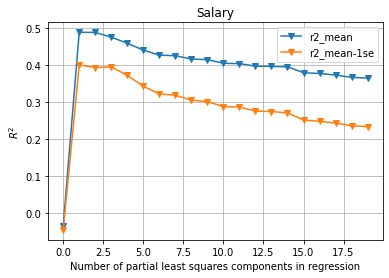

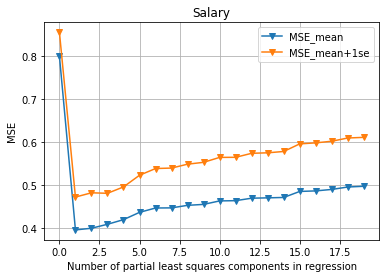

In [209]:
# set the random seed!
np.random.seed(1)
# Split into training and test sets
df_train, df_test = train_test_split(df, test_size=0.5)

def mean_and_std(x):
    res = {}
    for k, v in x.items():
        if 'test_' in k:
            k = k.replace('test_', '')
            res[k+'_mean'] = v.mean()
            res[k+'_se'] = v.std()/len(v)**0.5
    return res
            
    return {'mean': x.mean(), 'mean_std': x.std()/(len(x)**0.5)}

scores = pd.DataFrame([mean_anad_std(cv_score(PLSRegression(i) if i>0 else make_pipeline(FirstK(0), LinearRegression()), 
                                         **extract(df_train), 
                                         cv=10)
                               )
                       for i in np.arange(0, 20)])

scores = pd.DataFrame([mean_and_std(
    cross_validate(PLSRegression(i) if i>0 else make_pipeline(FirstK(0),LinearRegression()), 
                                               **extract(df_train), 
                                               cv=5, 
                                               scoring={'r2': make_scorer(r2_score), 'MSE': make_scorer(mean_squared_error)}
                                              )
                               )
                       for i in np.arange(0, 20)])

#plt.plot(scores, '-v')
scores['r2_mean-1se'] = scores['r2_mean']-scores['r2_se'] 
scores['MSE_mean+1se'] = scores['MSE_mean']+scores['MSE_se'] 

scores[['r2_mean', 'r2_mean-1se']].plot(marker='v')
plt.xlabel('Number of partial least squares components in regression')
plt.ylabel('$R^2$')
plt.title('Salary')
plt.grid();

scores[['MSE_mean', 'MSE_mean+1se']].plot(marker='v')
plt.xlabel('Number of partial least squares components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.grid();


In [207]:
scores

,r2_mean,r2_se,MSE_mean,MSE_se,r2_mean-1se,MSE_mean+1se
0,-0.031457,0.017571,235497.345617,40322.104404,-0.049028,275819.450021
1,0.383942,0.136113,139196.801565,32290.312501,0.247829,171487.114065
2,0.389299,0.167571,139148.710289,38628.388456,0.221728,177777.098745
3,0.360685,0.155626,143827.974959,35453.060018,0.205059,179281.034978
4,0.327381,0.159586,150031.987824,35858.599057,0.167795,185890.586882
5,0.227571,0.196269,172599.011288,43016.513420,0.031301,215615.524708
6,0.197391,0.192451,178377.821338,42437.932437,0.004941,220815.753775
7,0.217685,0.180389,173024.797769,39893.447640,0.037296,212918.245409
8,0.241822,0.180614,167222.205905,39760.406815,0.061207,206982.612720
9,0.233067,0.175432,167199.490442,38278.886852,0.057634,205478.377294


The lowest cross-validation error occurs when only $M = 6$, $M=11$ partial least
squares dimensions are used. But We now evaluate the corresponding test set
MSE:

In [205]:
# Prediction with test data
def MSE_and_R2(model, df):
    v = extract(df)
    X, y = v['X'], v['y']
    yhat = model.predict(X)
    return {'MSE': mean_squared_error(y_true=y, y_pred=yhat), 'R2': r2_score(y_true=y, y_pred=yhat)}

print('PLS(1) MSE={MSE:.2f}, R2={R2:.4f}'.format(**MSE_and_R2(PLSRegression(1).fit(*extract(df_train, return_dict=False)), df_test)))
print('PLS(2) MSE={MSE:.2f}, R2={R2:.4f}'.format(**MSE_and_R2(PLSRegression(2).fit(*extract(df_train, return_dict=False)), df_test)))


PLS(1) MSE=101462.13, R2=0.4129
PLS(2) MSE=102583.13, R2=0.4064


The test MSE is again comparable to the test MSE
obtained using ridge regression, the lasso, and PCR.